In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline

path_to_data = '../data/'

Loading features: 0it [00:00, ?it/s]


cmf_dim: 126, asset_dim: 5, num_assets: 488
Sharpe Ratio for the epoch: 3.2943
Average Weights:



,Weight
Cash,0.262539
BKNG,0.111186
GRMN,0.026983
IRM,0.024752
PTC,0.023254
...,...
TGT,0.000157
LYB,0.000155
CZR,0.000134
ALB,0.000127


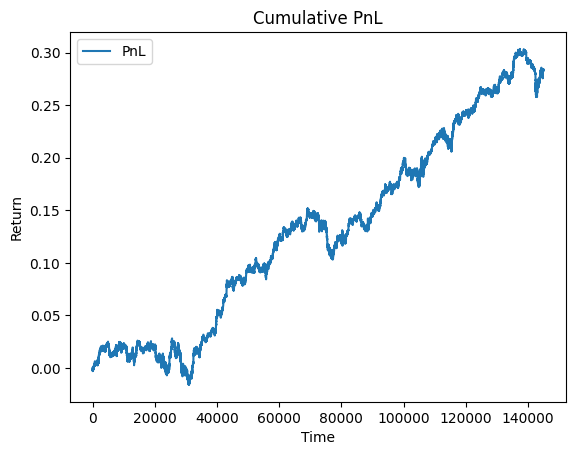

Sharpe Ratio for the epoch: 4.9815
Average Weights:



,Weight
Cash,0.289013
BKNG,0.115383
GRMN,0.027990
IRM,0.024925
IBM,0.023545
...,...
TGT,0.000137
LYB,0.000133
CZR,0.000116
ALB,0.000111


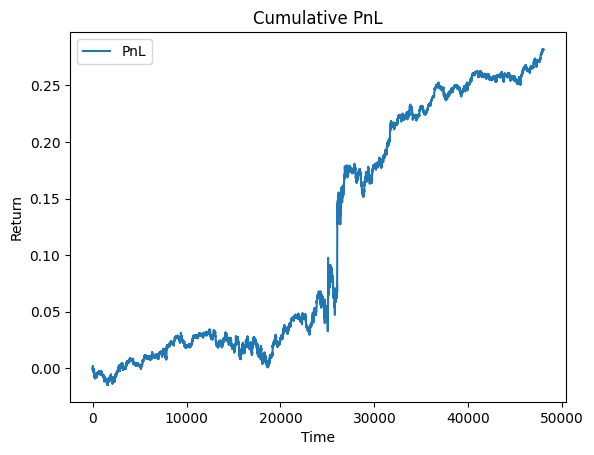

Sharpe Ratio for the epoch: 9.5469
Average Weights:



,Weight
Cash,0.844824
BKNG,0.034746
FICO,0.017641
NVR,0.016001
MPWR,0.012474
...,...
LYB,0.000008
LKQ,0.000008
ALB,0.000007
CZR,0.000007


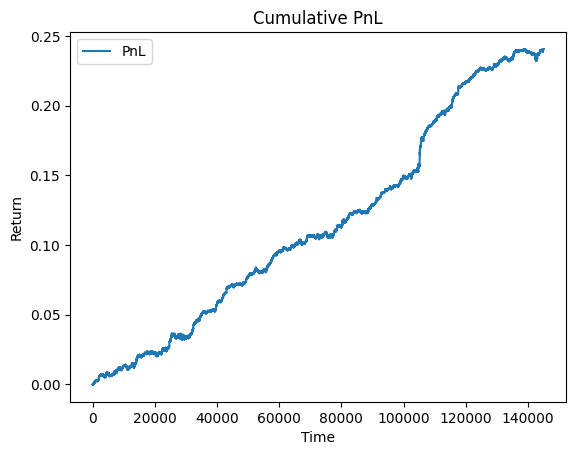

Sharpe Ratio for the epoch: 10.7888
Average Weights:



,Weight
Cash,0.848433
BKNG,0.035491
FICO,0.017269
NVR,0.016640
MPWR,0.012572
...,...
LYB,0.000007
LKQ,0.000007
ALB,0.000006
CZR,0.000006


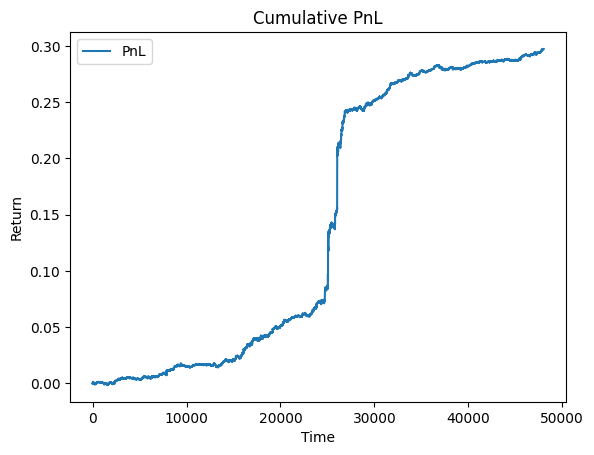

Sharpe Ratio for the epoch: 13.5336
Average Weights:



,Weight
Cash,0.911533
BKNG,0.023570
FICO,0.011768
NVR,0.011091
MPWR,0.009313
...,...
AAL,0.000001
CZR,0.000001
AMCR,0.000001
DOW,0.000001


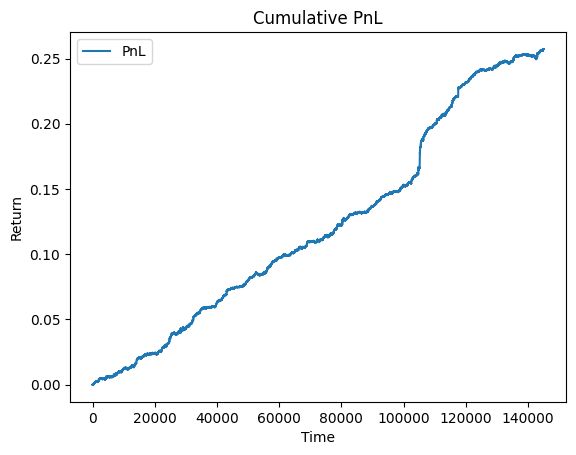

Sharpe Ratio for the epoch: 12.9477
Average Weights:



,Weight
Cash,9.039559e-01
BKNG,2.650182e-02
NVR,1.301859e-02
FICO,1.288607e-02
MPWR,1.021499e-02
...,...
AAL,1.179980e-06
CZR,1.151364e-06
AMCR,1.073567e-06
DOW,1.058258e-06


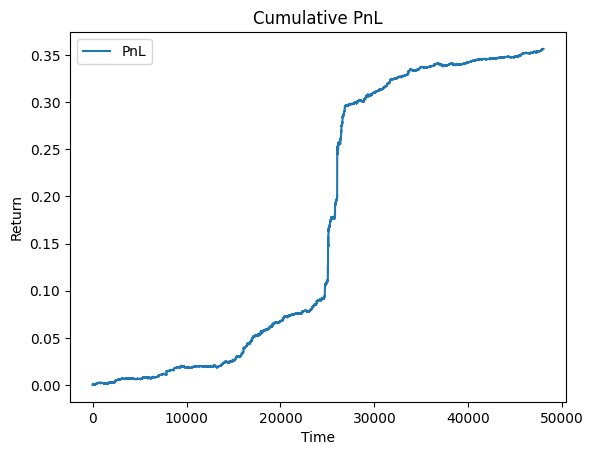

Sharpe Ratio for the epoch: 16.6976
Average Weights:



,Weight
Cash,9.182597e-01
BKNG,2.141223e-02
FICO,1.063049e-02
NVR,1.009130e-02
MPWR,8.465969e-03
...,...
AES,3.022559e-07
F,2.591049e-07
AAL,2.243329e-07
BEN,2.116533e-07


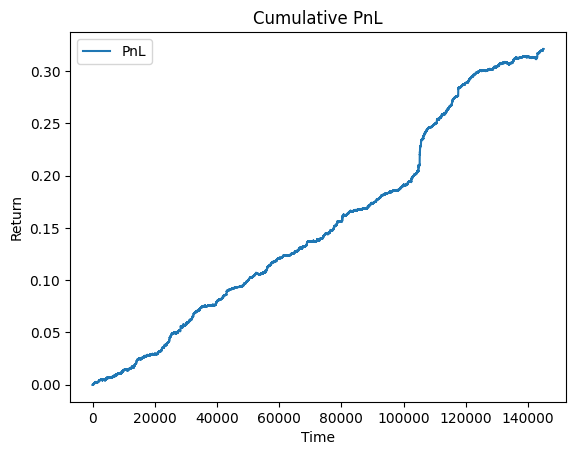

Sharpe Ratio for the epoch: 15.6533
Average Weights:



,Weight
Cash,9.075253e-01
BKNG,2.474368e-02
NVR,1.239230e-02
FICO,1.216518e-02
MPWR,9.449109e-03
...,...
AES,2.841396e-07
F,2.415668e-07
AAL,2.098654e-07
BEN,1.991226e-07


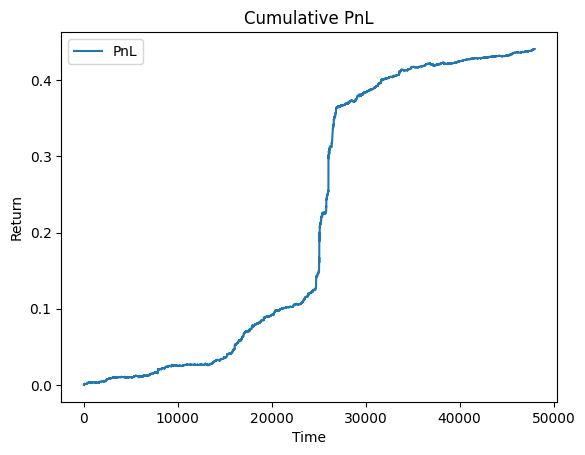

Sharpe Ratio for the epoch: 19.2579
Average Weights:



,Weight
Cash,9.148732e-01
BKNG,2.248450e-02
FICO,1.109327e-02
NVR,1.063373e-02
MPWR,8.990909e-03
...,...
HST,7.985663e-08
F,6.235605e-08
BEN,6.182216e-08
AAL,6.011241e-08


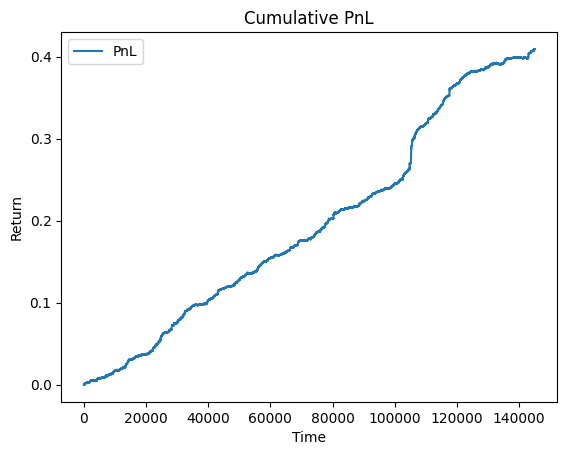

Sharpe Ratio for the epoch: 18.0951
Average Weights:



,Weight
Cash,9.026337e-01
BKNG,2.606401e-02
NVR,1.312726e-02
FICO,1.292992e-02
MPWR,9.942868e-03
...,...
HST,7.469703e-08
F,5.827219e-08
BEN,5.790028e-08
AAL,5.613120e-08


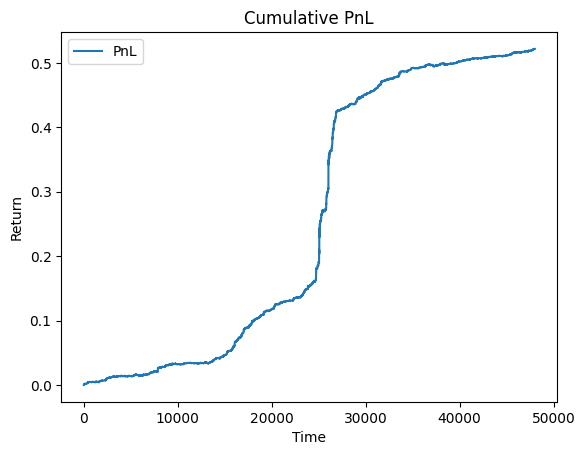

Sharpe Ratio for the epoch: 21.4359
Average Weights:



,Weight
Cash,9.043337e-01
BKNG,2.395377e-02
FICO,1.166559e-02
NVR,1.128553e-02
AZO,9.747362e-03
...,...
HST,2.647766e-08
BEN,2.224699e-08
AAL,2.076653e-08
F,2.050337e-08


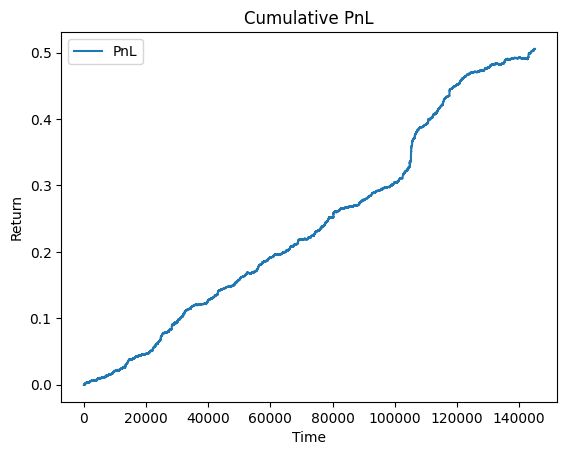

Sharpe Ratio for the epoch: 20.1515
Average Weights:



,Weight
Cash,8.913860e-01
BKNG,2.733272e-02
NVR,1.371666e-02
FICO,1.359253e-02
MPWR,1.051597e-02
...,...
HST,2.443725e-08
BEN,2.051411e-08
AAL,1.911786e-08
F,1.892397e-08


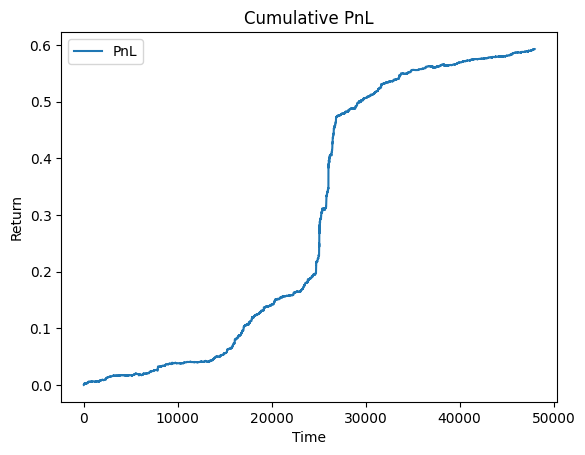

Sharpe Ratio for the epoch: 23.1865
Average Weights:



,Weight
Cash,8.931701e-01
BKNG,2.648133e-02
FICO,1.281842e-02
NVR,1.252162e-02
AZO,1.102164e-02
...,...
HST,1.057607e-08
BEN,9.289186e-09
AAL,8.491926e-09
F,8.171552e-09


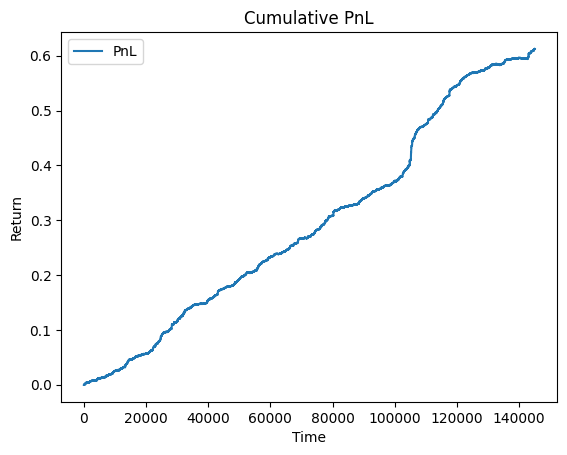

Sharpe Ratio for the epoch: 22.0642
Average Weights:



,Weight
Cash,8.799202e-01
BKNG,2.971229e-02
FICO,1.488907e-02
NVR,1.487993e-02
MPWR,1.153953e-02
...,...
HST,9.616651e-09
BEN,8.431550e-09
AAL,7.699256e-09
F,7.434160e-09


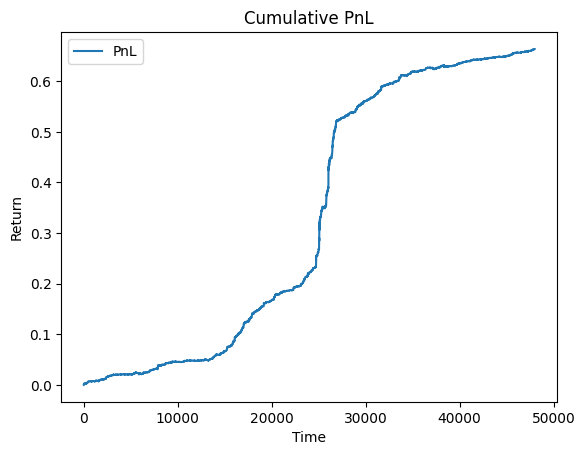

Sharpe Ratio for the epoch: 24.6290
Average Weights:



,Weight
Cash,8.815765e-01
BKNG,2.909179e-02
FICO,1.402378e-02
NVR,1.381094e-02
AZO,1.226795e-02
...,...
HST,4.592693e-09
BEN,4.141513e-09
AAL,3.740488e-09
F,3.546564e-09


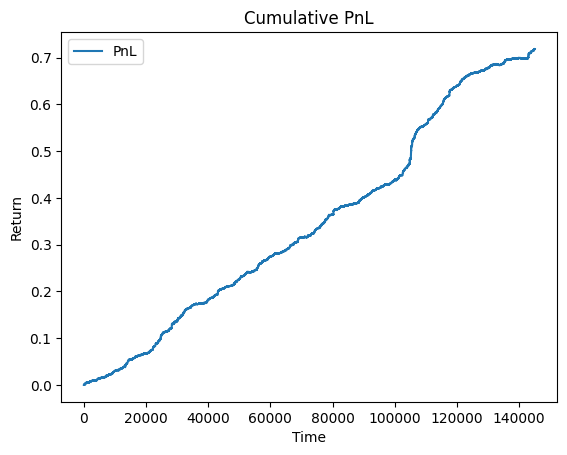

Sharpe Ratio for the epoch: 23.6658
Average Weights:



,Weight
Cash,8.680353e-01
BKNG,3.212323e-02
FICO,1.621989e-02
NVR,1.605432e-02
AZO,1.266006e-02
...,...
HST,4.121624e-09
BEN,3.708710e-09
AAL,3.346483e-09
F,3.185478e-09


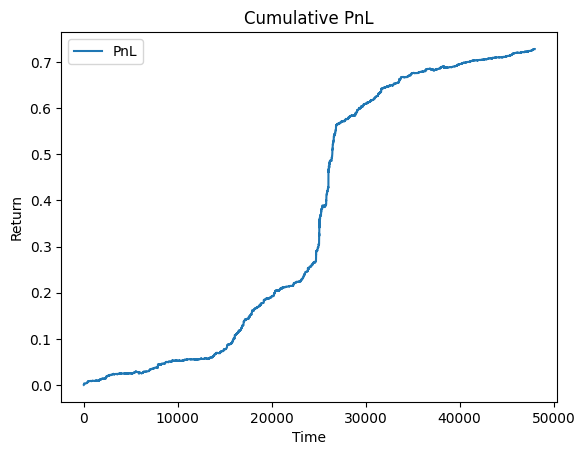

Sharpe Ratio for the epoch: 25.8367
Average Weights:



,Weight
Cash,8.701081e-01
BKNG,3.142642e-02
FICO,1.509124e-02
NVR,1.498510e-02
AZO,1.331778e-02
...,...
HST,2.076304e-09
BEN,1.903909e-09
AAL,1.706705e-09
F,1.603000e-09


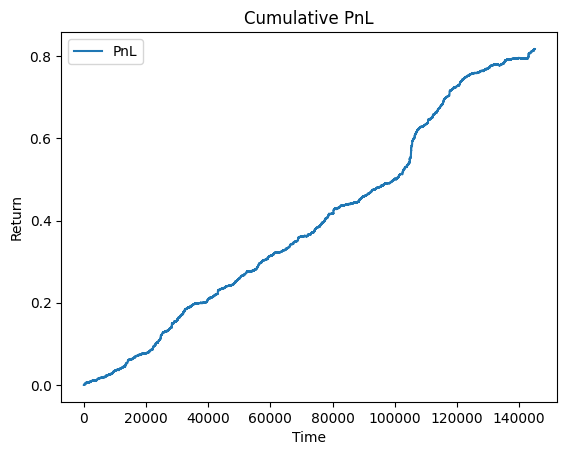

Sharpe Ratio for the epoch: 24.9015
Average Weights:



,Weight
Cash,8.561724e-01
BKNG,3.428206e-02
FICO,1.740576e-02
NVR,1.710404e-02
AZO,1.371114e-02
...,...
HST,1.845078e-09
BEN,1.687987e-09
AAL,1.511801e-09
F,1.426012e-09


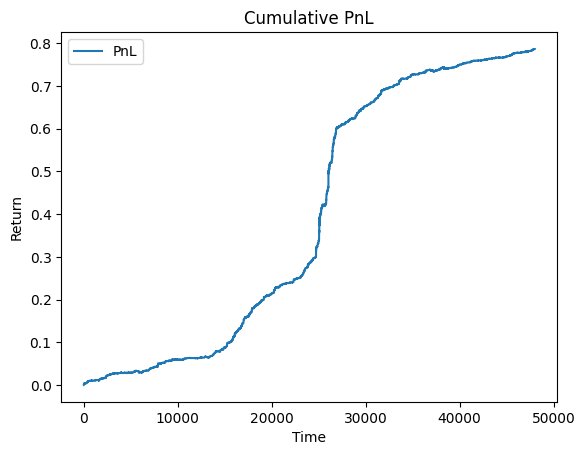

Sharpe Ratio for the epoch: 26.8576
Average Weights:



,Weight
Cash,8.596799e-01
BKNG,3.361255e-02
NVR,1.610103e-02
FICO,1.608806e-02
AZO,1.425991e-02
...,...
HST,9.613823e-10
BEN,8.915816e-10
AAL,7.952761e-10
F,7.421717e-10


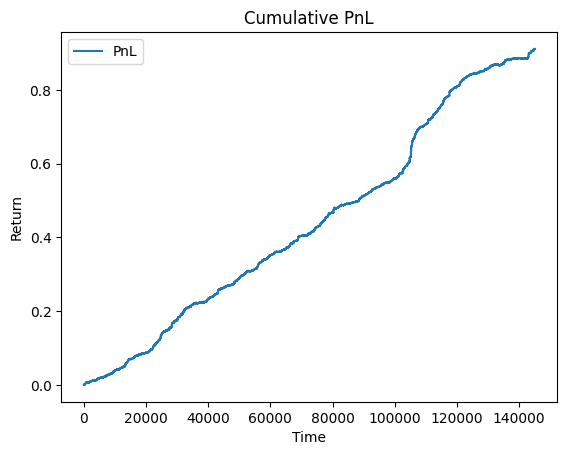

Sharpe Ratio for the epoch: 25.8153
Average Weights:



,Weight
Cash,8.452909e-01
BKNG,3.628660e-02
FICO,1.851374e-02
NVR,1.808136e-02
AZO,1.468537e-02
...,...
HST,8.476437e-10
BEN,7.842995e-10
AAL,6.988972e-10
F,6.551724e-10


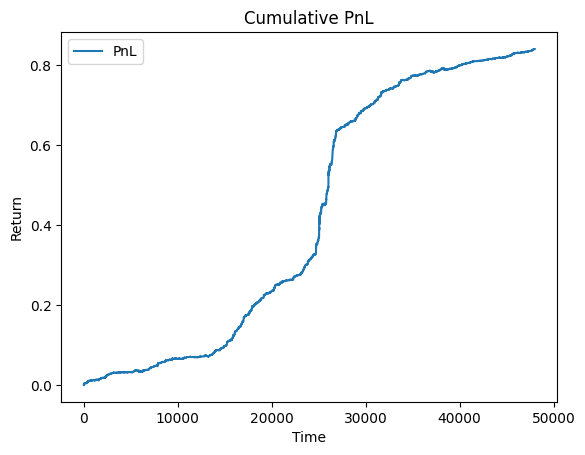

In [2]:
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator
import torch
from tqdm import tqdm

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

pipeline = FeaturesPipeline(path_to_data, padding=35, chunk_size=1000,
                        split_dates=split_dates,
                        split_names=split_names)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break

print(f"cmf_dim: {cmf_dim}, asset_dim: {asset_dim}, num_assets: {num_assets}")

model = SimplePortfolioAllocator(
    cmf_dim=cmf_dim,
    asset_dim=asset_dim,
    num_assets=num_assets,
    hidden_cmf=64,
    hidden_asset=32,
    head_hidden=16
)

# Big NN
# Sharpe Ratio (MSE-guided) for the epoch: 0.0106
# Total MSE loss for the epoch: 0.0000007199
# Pnl : 0.2

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 100 # Количество эпох обучения
for epoch in tqdm(range(num_epochs)):
    loss_fn = StreamingSharpeLoss(
        asset_names=pipeline.reader.asset_names + ['Cash'],  # Добавляем Cash в список активов
    )
    loss_fn.reset()
    pipeline.reset()
    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)       # (T, n_assets)
 
        if len(common_feats) != 1000:
            continue

        optimizer.zero_grad()

        # Вычисляем веса
        weights = model(common_feats, asset_feats)  # (T, n_assets)
        # Обновляем метрику
        loss_value = loss_fn.forward(
            weights=weights,
            returns=fut_ret,
            min_prices=min_prices,
            market_caps=market_caps
        )
        loss_value.backward()

        optimizer.step()

    if (epoch + 1) % 10 == 0:
        loss_fn.plot_whole_epoch_loss()  # Выводим Sharpe Ratio за эпоху
    loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

    for common_feats, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):
        common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps,  dtype=torch.float32).to(device)

        if len(common_feats) != 1000:
            continue

        weights = model(common_feats, asset_feats)
        loss_fn.forward(weights=weights, returns=fut_ret, min_prices=min_prices, market_caps=market_caps)

    if (epoch + 1) % 10 == 0:
        loss_fn.plot_whole_epoch_loss()
    loss_fn.reset()